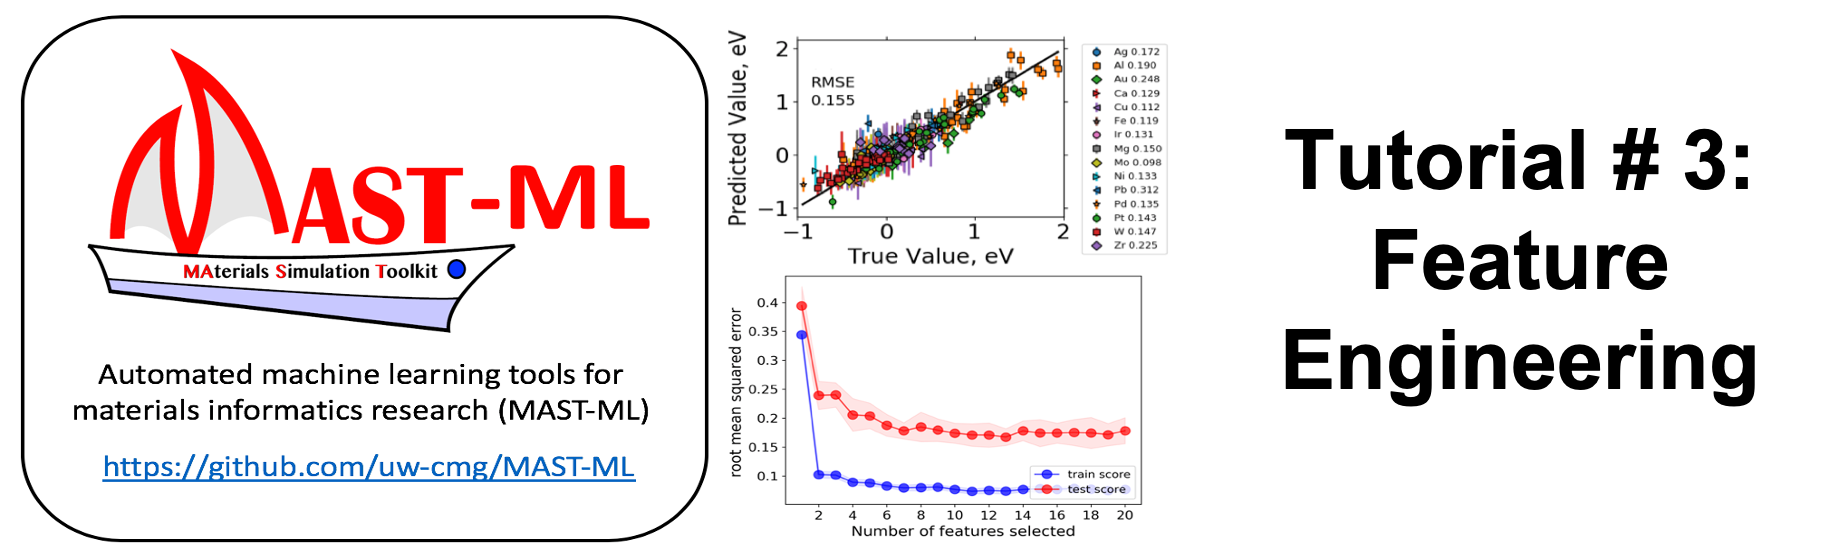

# Welcome to the third MAST-ML tutorial notebook, 

# Feature Engineering with MAST-ML! 

## In this notebook, we will learn different ways to generate, preprocess, and select features:

1. [Set up MAST-ML on Colab and begin session](#task1)
2. [Generate features based on material composition](#task2)
3. [Generate one-hot encoded features based on group labels](#task3)
4. [Preprocess features to be normalized](#task4)
5. [Select features using an ensemble model-based approach](#task5)
6. [Generate learning curves using a basic feature selection approach](#task6)
7. [Select features using forward selection](#task7)


## Task 1: Set up MAST-ML on Colab and begin session <a name="task1"></a>

If you are working on Google Colab and need to install MAST-ML, 
begin by pip installing MAST-ML to the Colab session
and install the needed dependencies:

In [1]:
!pip install mastml

     |████████████████████████████████| 122kB 16.0MB/s 
     |████████████████████████████████| 102kB 9.4MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 3.0MB 27.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 5.8MB 23.7MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 256kB 49.7MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 296kB 49.7MB/s 
     |████████████████████████████████| 102kB 12.2MB/s 
     |████████████████████████████████| 13.2MB 40.6MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 215kB 53.6MB/s 
 

In [1]:
import sklearn
sklearn.__version__

'0.24.1'

Sync your Google drive to Colab so that we can save MAST-ML results to our Google
Drive. If we save to the Colab session, the data will be deleted when the session 
ends.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Here we import the MAST-ML modules used in this tutorial

In [3]:
from mastml.mastml import Mastml
from mastml.datasets import LocalDatasets
from mastml.models import SklearnModel
from mastml.preprocessing import SklearnPreprocessor
from mastml.feature_selectors import SklearnFeatureSelector, EnsembleModelFeatureSelector
from mastml.feature_generators import ElementalFeatureGenerator, OneHotGroupGenerator
from mastml.learning_curve import LearningCurve
import numpy as np
from copy import copy
import mastml
import os
data_path = os.path.join(mastml.__path__[0], 'data')

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Figshare is an optional dependency. To import data from figshare, manually install figshare via git clone of git clone https://github.com/cognoma/figshare.git
forestci is an optional dependency. To install latest forestci compatabilty with scikit-learn>=0.24, run pip install git+git://github.com/scikit-learn-contrib/forest-confidence-interval.git


Here, we set the name of the savepath to save MAST-ML results to, and initialize
our MAST-ML run

When the above command is run, a new folder with the name designated SAVEPATH is created.
This is where all of the output for the current MAST-ML run will be saved to.
Note that you can perform multiple runs with the same folder name, and the current datetime
will be appended to the name so that no data is lost or overwritten.

In [7]:
SAVEPATH = 'drive/MyDrive/MASTML_tutorial_3_FeatureEngineering'

mastml = Mastml(savepath=SAVEPATH)
savepath = mastml.get_savepath

drive/MyDrive/MASTML_tutorial_3_FeatureEngineering not empty. Renaming...


## Task 2: Generate features based on material composition <a name="task2"></a>

Let's import the diffusion data used in the previous tutorial again
using the LocalDatasets class. This time, we are using a version
where there are no X features, and we will proceed to generate new features

In [5]:
target = 'E_regression'
extra_columns = ['Material compositions 1', 'Material compositions 2', 'Material compositions joined']

d = LocalDatasets(file_path=data_path+'/diffusion_data_nofeatures.xlsx', 
                  target=target, 
                  extra_columns=extra_columns, 
                  group_column='Material compositions 1',
                  testdata_columns=None,
                  as_frame=True)

# Load the data with the load_data() method
data_dict = d.load_data()

# Designate the X, y and X_extra data 
X = data_dict['X']
y = data_dict['y']
X_extra = data_dict['X_extra']
groups = data_dict['groups']


If we look at the X feature data, we see that it is empty. We need to make some
features to described our data!

In [7]:
X

""
0
1
2
3
4
...
403
404
405
406


Since this dataset contains materials composition strings, we can create
features of the compositinos using elemental properties of the elements
in each composition. We can do that using the ElementalFeatureGenerator
class. The ElementalFeatureGenerator takes the following arguments:

composition_df : a dataframe with the composition strings to featurize
feature_types : list denoting which types of elemental feature operations to make
remove_constant_columns : bool denoting whether columns with same value for each point are removed

The evaluate() method conducts the feature generation and saves the output to a designated
folder under the provided savepath. In this folder, the generated data is saved as the file
generated_features.xlsx

In [8]:
X, y = ElementalFeatureGenerator(composition_df=X_extra['Material compositions joined'], 
                                 feature_types=['composition_avg', 'arithmetic_avg', 'max', 'min', 'difference'], 
                                 remove_constant_columns=True).evaluate(X=X, y=y, savepath=savepath, make_new_dir=True)

Dropping 5/440 generated columns due to missing values


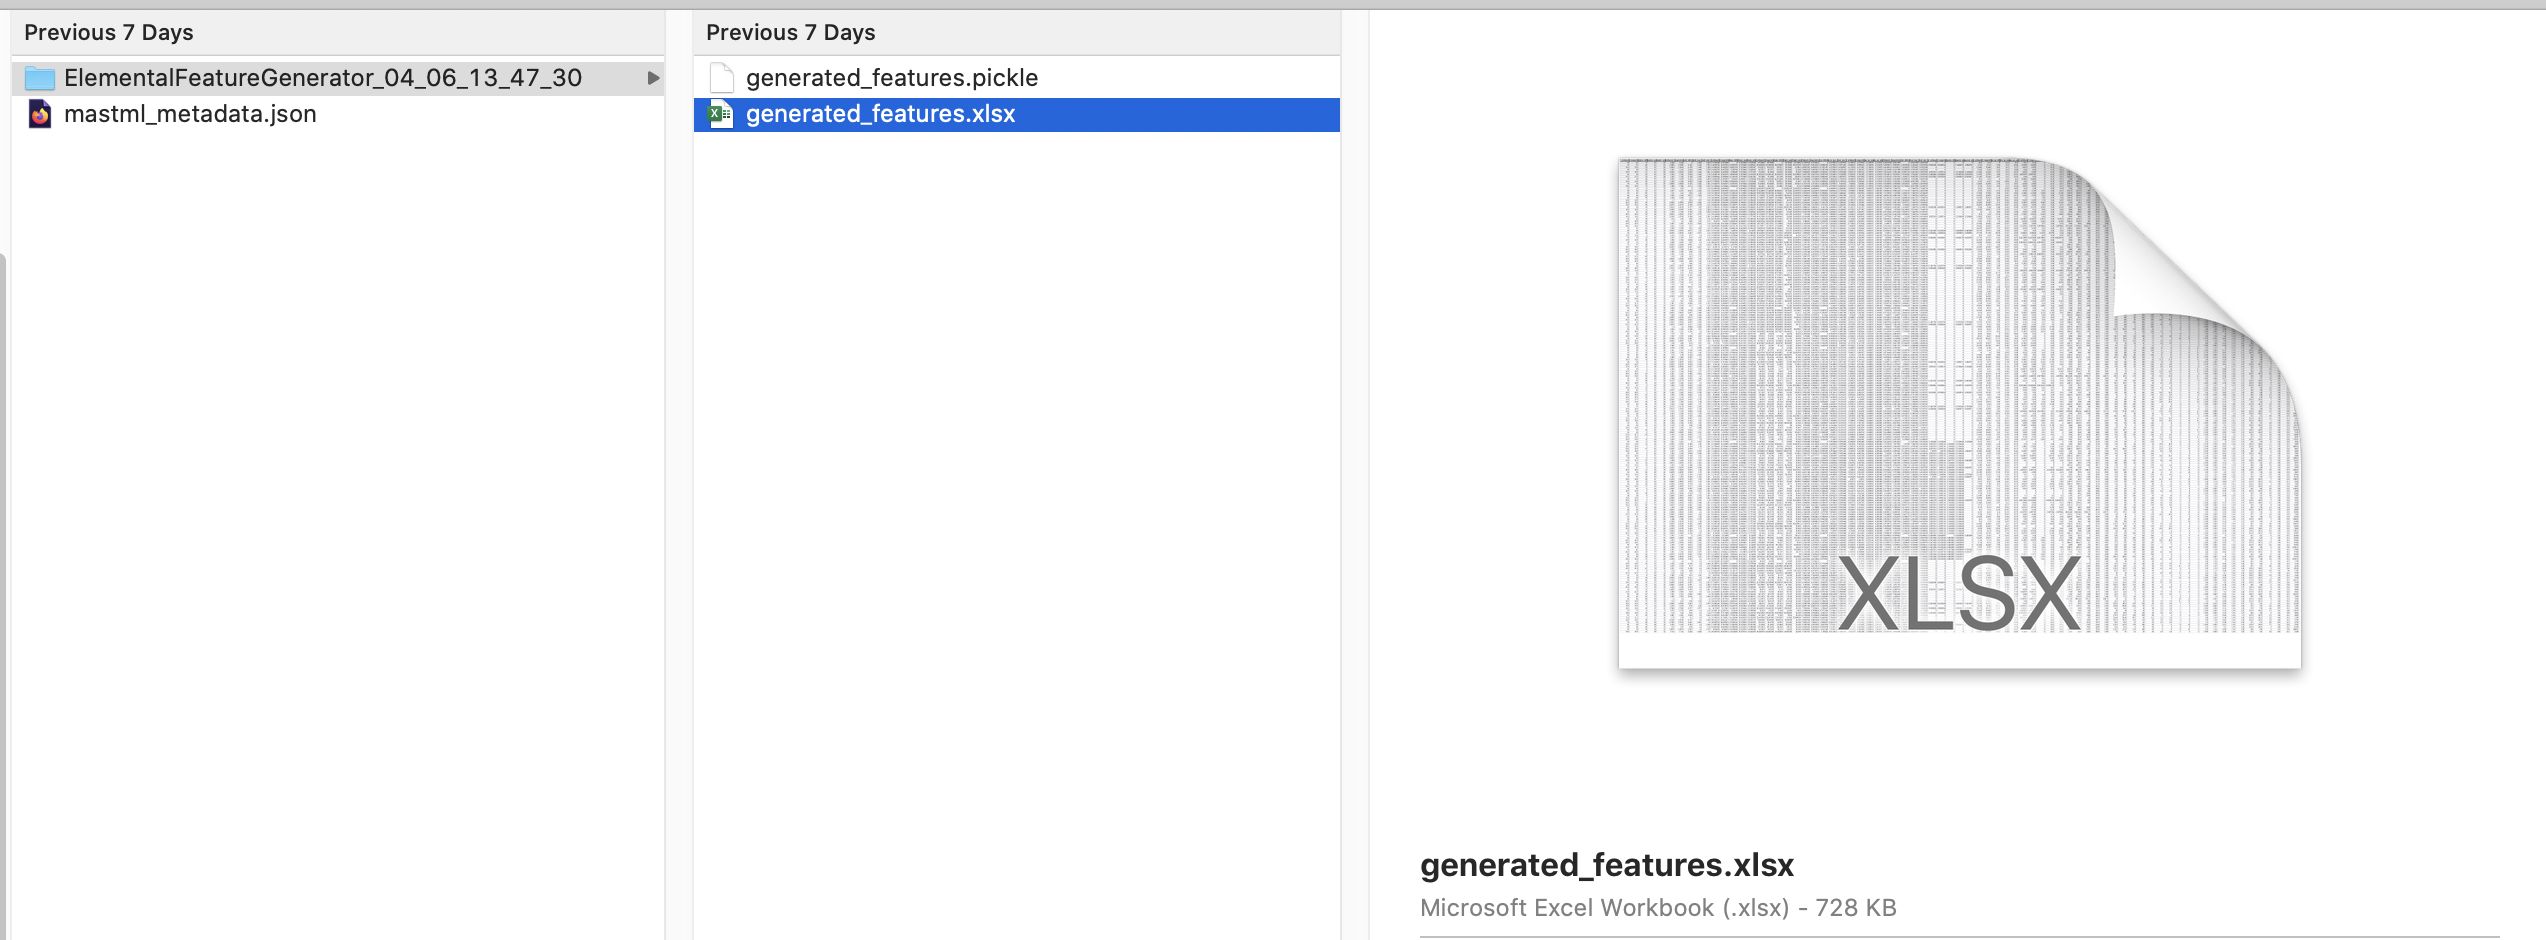

Now let's examine what the X data look like:

We can see that we now have 404 generated features based on properties of the elements

In [9]:
X

,AtomicNumber_arithmetic_average,AtomicNumber_composition_average,AtomicNumber_difference,AtomicNumber_max_value,AtomicNumber_min_value,AtomicRadii_arithmetic_average,AtomicRadii_composition_average,AtomicRadii_difference,AtomicRadii_max_value,AtomicRadii_min_value,AtomicVolume_arithmetic_average,AtomicVolume_composition_average,AtomicVolume_difference,AtomicVolume_max_value,AtomicVolume_min_value,AtomicWeight_arithmetic_average,AtomicWeight_composition_average,AtomicWeight_difference,AtomicWeight_max_value,AtomicWeight_min_value,BCCefflatcnt_arithmetic_average,BCCefflatcnt_composition_average,BCCefflatcnt_difference,BCCefflatcnt_max_value,BCCefflatcnt_min_value,BCCenergy_pa_arithmetic_average,BCCenergy_pa_composition_average,BCCenergy_pa_max_value,BCCenergy_pa_min_value,BCCfermi_arithmetic_average,BCCfermi_composition_average,BCCfermi_difference,BCCfermi_max_value,BCCfermi_min_value,BCCmagmom_arithmetic_average,BCCmagmom_composition_average,BCCmagmom_difference,BCCmagmom_max_value,BCCmagmom_min_value,BCCvolume_pa_arithmetic_average,...,SpaceGroupNumber_arithmetic_average,SpaceGroupNumber_composition_average,SpaceGroupNumber_difference,SpaceGroupNumber_max_value,SpaceGroupNumber_min_value,SpecificHeatCapacity_arithmetic_average,SpecificHeatCapacity_composition_average,SpecificHeatCapacity_difference,SpecificHeatCapacity_max_value,SpecificHeatCapacity_min_value,ThermalConductivity_arithmetic_average,ThermalConductivity_composition_average,ThermalConductivity_difference,ThermalConductivity_max_value,ThermalConductivity_min_value,ThermalExpansionCoefficient_arithmetic_average,ThermalExpansionCoefficient_composition_average,ThermalExpansionCoefficient_difference,ThermalExpansionCoefficient_max_value,ThermalExpansionCoefficient_min_value,ThirdIonizationEnergy_arithmetic_average,ThirdIonizationEnergy_composition_average,ThirdIonizationEnergy_difference,ThirdIonizationEnergy_max_value,ThirdIonizationEnergy_min_value,n_ws^third_arithmetic_average,n_ws^third_composition_average,n_ws^third_difference,n_ws^third_max_value,n_ws^third_min_value,phi_arithmetic_average,phi_composition_average,phi_difference,phi_max_value,phi_min_value,valence_arithmetic_average,valence_composition_average,valence_difference,valence_max_value,valence_min_value
0,47.0,47.0,0.0,47.0,47.0,1.4440,1.4440,0.000,1.444,1.444,17.075648,17.075648,0.000000,17.075648,17.075648,107.868200,107.868200,0.000000,107.86820,107.868200,6.375951,6.375951,0.000000,6.375951,6.375951,-2.719979,-2.719979,-2.719979,-2.719979,4.052760,4.052760,0.000000,4.052760,4.052760,0.000000,0.000000,0.0,0.000000,0.000000,16.200,...,225.0,225.0,0.0,225.0,225.0,0.2350,0.2350,0.000,0.235,0.235,429.00,429.00,0.0,429.0,429.0,18.90,18.90,0.0,18.9,18.9,34.8300,34.8300,0.000,34.830,34.830,1.360,1.360,0.00,1.36,1.36,4.350,4.350,0.00,4.35,4.35,2.0,2.0,0.0,2.0,2.0
1,37.0,37.0,20.0,47.0,27.0,1.3485,1.3485,0.191,1.444,1.253,14.035754,14.035754,6.079787,17.075648,10.995861,83.400698,83.400698,48.935005,107.86820,58.933195,5.941635,5.941635,0.868633,6.375951,5.507318,-4.850033,-4.850033,-2.719979,-2.719979,5.096587,5.096587,2.087655,6.140415,4.052760,0.842019,0.842019,0.0,1.684037,1.684037,13.320,...,209.5,209.5,31.0,225.0,194.0,0.3280,0.3280,0.186,0.421,0.235,264.50,264.50,329.0,429.0,100.0,15.95,15.95,5.9,18.9,13.0,34.1650,34.1650,1.330,34.830,33.500,1.555,1.555,0.39,1.75,1.36,4.725,4.725,0.75,5.10,4.35,2.5,2.5,1.0,3.0,2.0
2,35.5,35.5,23.0,47.0,24.0,1.3465,1.3465,0.195,1.444,1.249,14.584293,14.584293,4.982710,17.075648,12.092937,79.932150,79.932150,55.872100,107.86820,51.996100,6.004376,6.004376,0.743151,6.375951,5.632801,-6.112393,-6.112393,-2.719979,-2.719979,6.014901,6.014901,3.924283,7.977043,4.052760,0.000000,0.000000,0.0,0.000000,0.000000,13.685,...,227.0,227.0,4.0,229.0,225.0,0.3420,0.3420,0.214,0.449,0.235,261.35,261.35,335.3,429.0,93.7,11.90,11.90,14.0,18.9,4.9,32.8950,32.8950,3.870,34.830,30.960,1.545,1.545,0.37,1.73,1.36,4.500,4.500,0.30,4.65,4.35,4.0,4.0,4.0,6.0,2.0
3,38.0,38.0,18.0,47.0,29.0,1.361

## Task 3: Generate one-hot encoded features based on group labels <a name="task3"></a>

We have generated a large feature set based on properties of the elements,
but we can also add more features based on one-hot encoding of the 
different host groups each data point corresponds to. The host elements
are contained in the Material Compositions 1 column in X_extra

We can also view the unique groups only:

In [10]:
np.unique(X_extra['Material compositions 1'])

array(['Ag', 'Al', 'Au', 'Ca', 'Cu', 'Fe', 'Ir', 'Mg', 'Mo', 'Ni', 'Pb',
       'Pd', 'Pt', 'W', 'Zr'], dtype=object)

There are 15 unique groups. We can create one-hot encoded vectors of 
each group with the OneHotGroupGenerator class. Like with the previous
feature generation scheme, running the evaluate() method for this class
will create an output folder with the generated data saved as the file
generated_features.xlsx

In [9]:
X, y = OneHotGroupGenerator(groups=X_extra['Material compositions 1']).evaluate(X=X, y=y, savepath=savepath, make_new_dir=True)

Let's look at our generated features once more:

We can now see that we have 419 features, meaning we added 15 new one-hot 
encoded features to our previous set of 404 elemental features. The new
one-hot encoded features are appended to the right-hand end of the 
dataframe.

In [12]:
X

,AtomicNumber_arithmetic_average,AtomicNumber_composition_average,AtomicNumber_difference,AtomicNumber_max_value,AtomicNumber_min_value,AtomicRadii_arithmetic_average,AtomicRadii_composition_average,AtomicRadii_difference,AtomicRadii_max_value,AtomicRadii_min_value,AtomicVolume_arithmetic_average,AtomicVolume_composition_average,AtomicVolume_difference,AtomicVolume_max_value,AtomicVolume_min_value,AtomicWeight_arithmetic_average,AtomicWeight_composition_average,AtomicWeight_difference,AtomicWeight_max_value,AtomicWeight_min_value,BCCefflatcnt_arithmetic_average,BCCefflatcnt_composition_average,BCCefflatcnt_difference,BCCefflatcnt_max_value,BCCefflatcnt_min_value,BCCenergy_pa_arithmetic_average,BCCenergy_pa_composition_average,BCCenergy_pa_max_value,BCCenergy_pa_min_value,BCCfermi_arithmetic_average,BCCfermi_composition_average,BCCfermi_difference,BCCfermi_max_value,BCCfermi_min_value,BCCmagmom_arithmetic_average,BCCmagmom_composition_average,BCCmagmom_difference,BCCmagmom_max_value,BCCmagmom_min_value,BCCvolume_pa_arithmetic_average,...,ThermalExpansionCoefficient_arithmetic_average,ThermalExpansionCoefficient_composition_average,ThermalExpansionCoefficient_difference,ThermalExpansionCoefficient_max_value,ThermalExpansionCoefficient_min_value,ThirdIonizationEnergy_arithmetic_average,ThirdIonizationEnergy_composition_average,ThirdIonizationEnergy_difference,ThirdIonizationEnergy_max_value,ThirdIonizationEnergy_min_value,n_ws^third_arithmetic_average,n_ws^third_composition_average,n_ws^third_difference,n_ws^third_max_value,n_ws^third_min_value,phi_arithmetic_average,phi_composition_average,phi_difference,phi_max_value,phi_min_value,valence_arithmetic_average,valence_composition_average,valence_difference,valence_max_value,valence_min_value,Material compositions 1_0,Material compositions 1_1,Material compositions 1_2,Material compositions 1_3,Material compositions 1_4,Material compositions 1_5,Material compositions 1_6,Material compositions 1_7,Material compositions 1_8,Material compositions 1_9,Material compositions 1_10,Material compositions 1_11,Material compositions 1_12,Material compositions 1_13,Material compositions 1_14
0,47.0,47.0,0.0,47.0,47.0,1.4440,1.4440,0.000,1.444,1.444,17.075648,17.075648,0.000000,17.075648,17.075648,107.868200,107.868200,0.000000,107.86820,107.868200,6.375951,6.375951,0.000000,6.375951,6.375951,-2.719979,-2.719979,-2.719979,-2.719979,4.052760,4.052760,0.000000,4.052760,4.052760,0.000000,0.000000,0.0,0.000000,0.000000,16.200,...,18.90,18.90,0.0,18.9,18.9,34.8300,34.8300,0.000,34.830,34.830,1.360,1.360,0.00,1.36,1.36,4.350,4.350,0.00,4.35,4.35,2.0,2.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37.0,37.0,20.0,47.0,27.0,1.3485,1.3485,0.191,1.444,1.253,14.035754,14.035754,6.079787,17.075648,10.995861,83.400698,83.400698,48.935005,107.86820,58.933195,5.941635,5.941635,0.868633,6.375951,5.507318,-4.850033,-4.850033,-2.719979,-2.719979,5.096587,5.096587,2.087655,6.140415,4.052760,0.842019,0.842019,0.0,1.684037,1.684037,13.320,...,15.95,15.95,5.9,18.9,13.0,34.1650,34.1650,1.330,34.830,33.500,1.555,1.555,0.39,1.75,1.36,4.725,4.725,0.75,5.10,4.35,2.5,2.5,1.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,35.5,35.5,23.0,47.0,24.0,1.3465,1.3465,0.195,1.444,1.249,14.584293,14.584293,4.982710,17.075648,12.092937,79.932150,79.932150,55.872100,107.86820,51.996100,6.004376,6.004376,0.743151,6.375951,5.632801,-6.112393,-6.112393,-2.719979,-2.719979,6.014901,6.014901,3.924283,7.977043,4.052760,0.000000,0.000000,0.0,0.000000,0.000000,13.685,...,11.90,11.90,14.0,18.9,4.9,32.8950,32.8950,3.870,34.830,30.960,1.545,1.545,0.37,1.73,1.36,4.500,4.500,0.30,4.65,4.35,4.0,4.0,4.0,6.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,38.0,38.0,18.0,47.0,29.0,1.3610,1.3610,0.166,1.444,1.278,14.452795,14.452795,5.245706,17.075648,11.829942,85.707100,85.707100,44.322200,107.86820,63.546000,5.996791,5.996791,0.758320,6.375951,5.617632,-3.181433,-3.181433,-2.71997

## Task 4: Preprocess features to be normalized <a name="task4"></a>

We now have a complete set of reasonable features to use going forward.
However, our features span different ranges based on their physical meaning, 
which can distort how a machine learning model may behave. It is common
to normalize or standardize the data in some way prior to fitting. Here,
we invoke a common approach which is to normalize the data so that
each feature has mean of 0 and standard deviation of 1. We can do this
with the StandardScaler method in the SklearnPreprocessor class

In [10]:
preprocessor = SklearnPreprocessor(preprocessor='StandardScaler', as_frame=True)

If we want to go ahead an normalize our full dataset in one go, we can
do that now. Alternatively, we will see in the next tutorial that you can 
pass the preprocessor object into a MAST-ML data splitter workflow, where
the preprocessor will be used in each train/test split to standardize the
data.

In [11]:
X = preprocessor.evaluate(X=X, y=y, savepath=savepath, make_new_dir=True)
Xcopy = copy(X) # Reserve this copy of the full dataset for later

The resulting normalized dataset is saved to the file data_preprocessed.xlsx,
and the fitted preprocessor class is saved as a .pkl file. This will be useful
for preprocessing new data used for future predictions or if the model is 
to be uploaded to the model hosting service DLHub

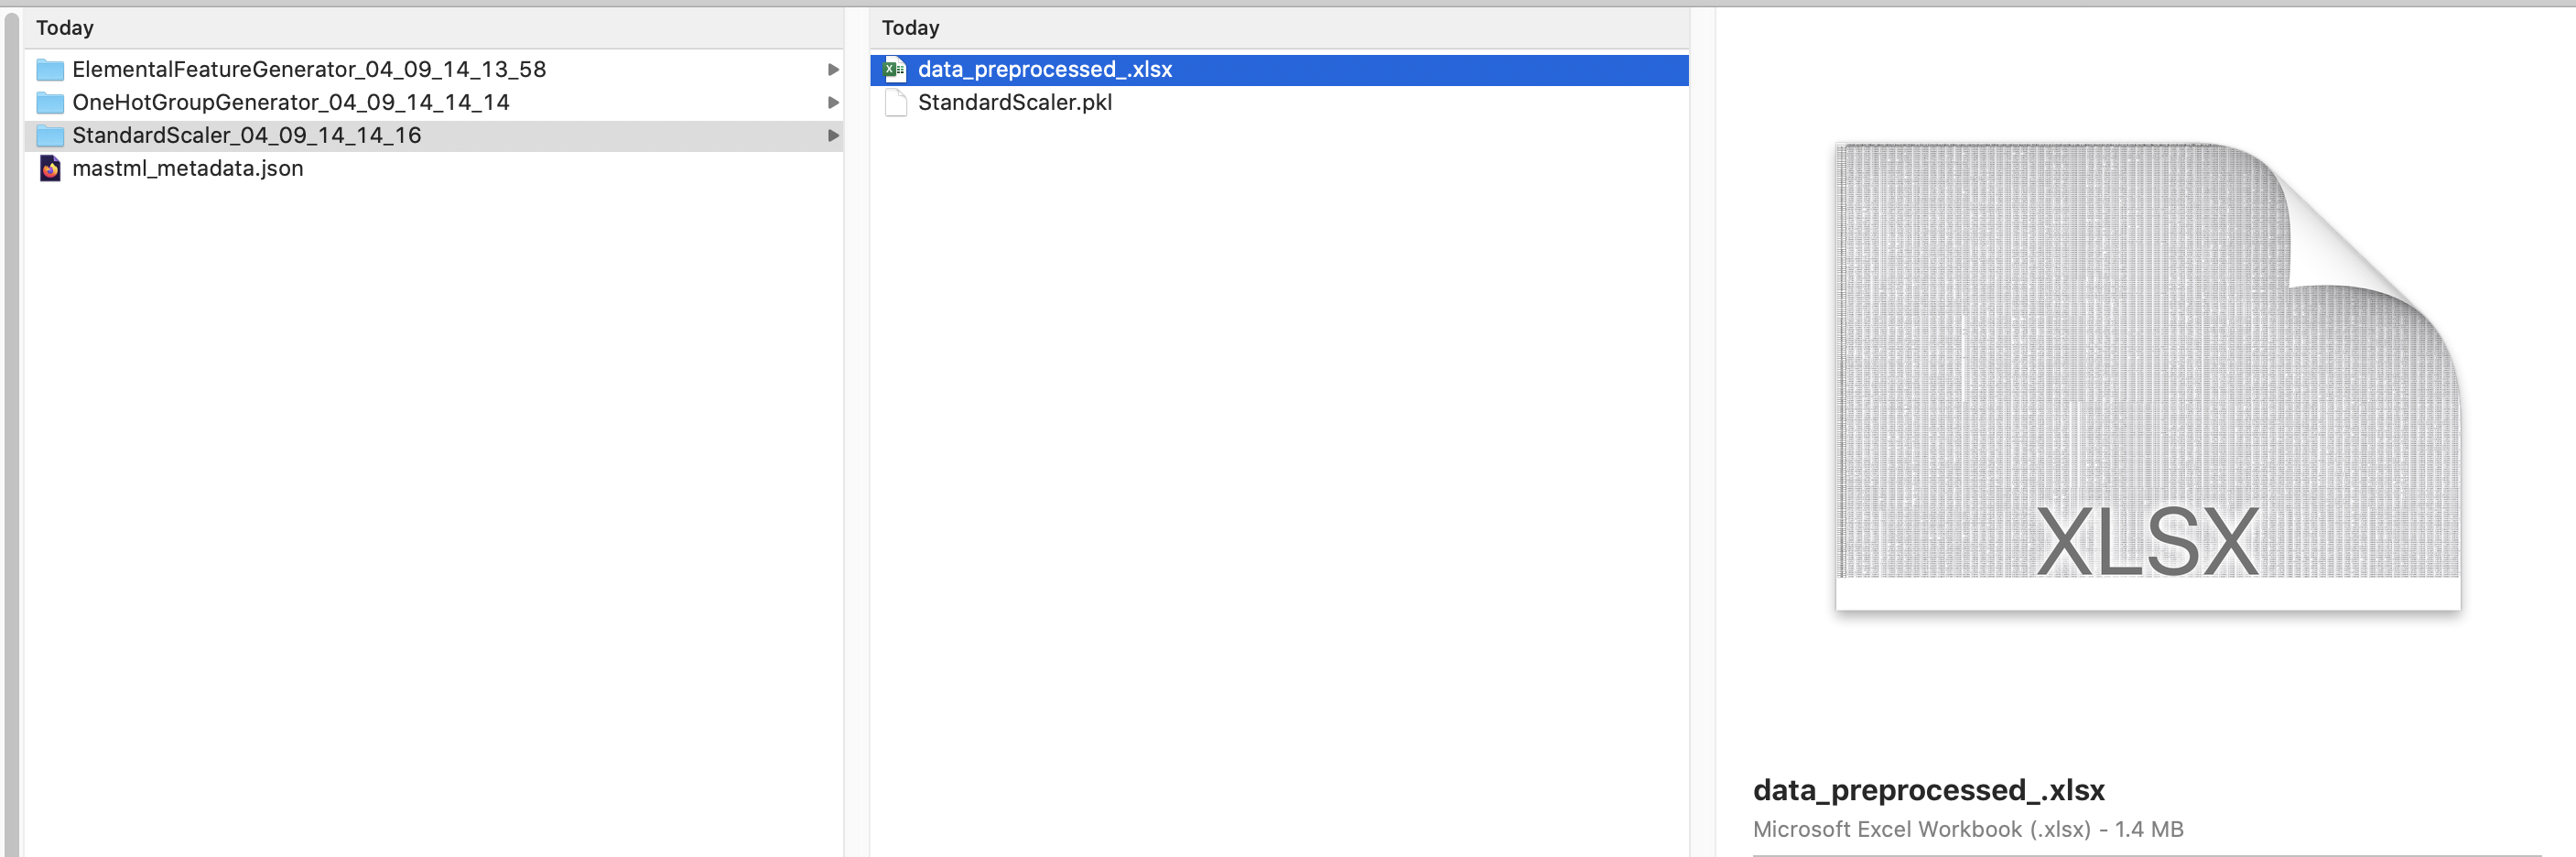

Let's look at our newly preprocessed data:

In [15]:
X

,AtomicNumber_arithmetic_average,AtomicNumber_composition_average,AtomicNumber_difference,AtomicNumber_max_value,AtomicNumber_min_value,AtomicRadii_arithmetic_average,AtomicRadii_composition_average,AtomicRadii_difference,AtomicRadii_max_value,AtomicRadii_min_value,AtomicVolume_arithmetic_average,AtomicVolume_composition_average,AtomicVolume_difference,AtomicVolume_max_value,AtomicVolume_min_value,AtomicWeight_arithmetic_average,AtomicWeight_composition_average,AtomicWeight_difference,AtomicWeight_max_value,AtomicWeight_min_value,BCCefflatcnt_arithmetic_average,BCCefflatcnt_composition_average,BCCefflatcnt_difference,BCCefflatcnt_max_value,BCCefflatcnt_min_value,BCCenergy_pa_arithmetic_average,BCCenergy_pa_composition_average,BCCenergy_pa_max_value,BCCenergy_pa_min_value,BCCfermi_arithmetic_average,BCCfermi_composition_average,BCCfermi_difference,BCCfermi_max_value,BCCfermi_min_value,BCCmagmom_arithmetic_average,BCCmagmom_composition_average,BCCmagmom_difference,BCCmagmom_max_value,BCCmagmom_min_value,BCCvolume_pa_arithmetic_average,...,ThermalExpansionCoefficient_arithmetic_average,ThermalExpansionCoefficient_composition_average,ThermalExpansionCoefficient_difference,ThermalExpansionCoefficient_max_value,ThermalExpansionCoefficient_min_value,ThirdIonizationEnergy_arithmetic_average,ThirdIonizationEnergy_composition_average,ThirdIonizationEnergy_difference,ThirdIonizationEnergy_max_value,ThirdIonizationEnergy_min_value,n_ws^third_arithmetic_average,n_ws^third_composition_average,n_ws^third_difference,n_ws^third_max_value,n_ws^third_min_value,phi_arithmetic_average,phi_composition_average,phi_difference,phi_max_value,phi_min_value,valence_arithmetic_average,valence_composition_average,valence_difference,valence_max_value,valence_min_value,Material compositions 1_0,Material compositions 1_1,Material compositions 1_2,Material compositions 1_3,Material compositions 1_4,Material compositions 1_5,Material compositions 1_6,Material compositions 1_7,Material compositions 1_8,Material compositions 1_9,Material compositions 1_10,Material compositions 1_11,Material compositions 1_12,Material compositions 1_13,Material compositions 1_14
0,0.348272,0.348272,-1.369606,-0.358844,1.218017,0.137574,0.137574,-1.151827,-0.370794,0.928492,-0.189743,-0.189743,-1.040919,-0.564380,0.652637,0.252398,0.252398,-1.333732,-0.416494,1.160051,-0.089744,-0.089744,-1.254233,-0.595854,0.644878,1.386573,1.386573,0.931053,0.931053,-1.476460,-1.476460,-1.359771,-1.917090,-0.638654,-0.472699,-0.472699,-0.363092,-0.481265,-0.294029,-0.211146,...,0.411619,0.411619,-0.793083,-0.117746,1.631858,0.386365,0.386365,-0.547625,-0.197028,0.433561,-0.768754,-0.768754,-1.258567,-1.573418,-0.193920,-0.188275,-0.188275,-1.289040,-0.876125,0.325247,-1.676966,-1.676966,-1.281784,-1.833166,-0.914448,6.007571,-0.377964,-0.166457,-0.122169,-0.32969,-0.32969,-0.166457,-0.373718,-0.29173,-0.32969,-0.141421,-0.281718,-0.281718,-0.296648,-0.195366
1,-0.285939,-0.285939,-0.322479,-0.358844,-0.093718,-0.624665,-0.624665,0.196745,-0.370794,-0.866396,-0.774117,-0.774117,-0.124147,-0.564380,-0.957376,-0.341959,-0.341959,-0.375161,-0.416494,-0.117516,-0.897594,-0.897594,0.204143,-0.595854,-1.077253,0.484851,0.484851,0.931053,0.931053,-0.741689,-0.741689,-0.042789,-0.656636,-0.638654,1.741642,1.741642,-0.363092,1.882336,3.811591,-0.809010,...,0.086409,0.086409,-0.368968,-0.117746,0.591025,0.340227,0.340227,-0.462665,-0.197028,0.313157,0.158506,0.158506,0.673356,0.477555,-0.193920,0.401833,0.401833,0.008865,0.378880,0.325247,-1.247730,-1.247730,-0.582629,-1.194454,-0.914448,6.007571,-0.377964,-0.166457,-0.122169,-0.32969,-0.32969,-0.166457,-0.373718,-0.29173,-0.32969,-0.141421,-0.281718,-0.281718,-0.296648,-0.195366
2,-0.381070,-0.381070,-0.165410,-0.358844,-0.290479,-0.640628,-0.640628,0.224987,-0.370794,-0.903985,-0.668669,-0.668669,-0.289575,-0.564380,-0.666855,-0.426216,-0.426216,-0.239272,-0.416494,-0.298626,-0.780892,-0.780892,-0.006534,-0.595854,-0.828474,-0.049547,-0.049547,0.931053,0.

The data values are very different than they used to be! Let's look at the
mean and standard deviation of the first feature:

Indeed, we can see that the mean is very close to zero and the standard
deviation is very close to one

In [16]:
print(np.mean(X['AtomicNumber_arithmetic_average']), np.std(X['AtomicNumber_arithmetic_average']))

2.2653447745108894e-16 1.0000000000000002


## Task 5: Select features using an ensemble model-based approach <a name="task5"></a>

As you saw previously, we now have a lot of features in our feature set- 419
to be precise! It is unlikely that all of these features will be meaningful
in whatever model we develop. This is where feature selection methods come
into play. For the purposes of this tutorial, we will show off a couple
feature selection routines by selecting features for this full dataset. In
a later tutorial, we will show how the feature selection process can be
conducted for every train/test evaluation split, which is a more methodical
approach to feature engineering to prevent overfitting

Let's start by using the EnsembleModelFeatureSelector, which fits the data
using a random forest model, and selects features based on the resulting
random forest feature importance ranking:

In [13]:
model = SklearnModel(model='RandomForestRegressor')
selector = EnsembleModelFeatureSelector(model=model, 
                                        n_features_to_select=20)
X = selector.evaluate(X=X, y=y, savepath=savepath, make_new_dir=True)


We can see that a full spreadsheet of calculated feature importance rankings
has been saved in the EnsembleModelFeatureSelector_feature_importances.xlsx file,
and a text file of the 20 selected features is printed in the selected_features.txt file.
Also, the resulting selected feature set is saved as selected_features.xlsx

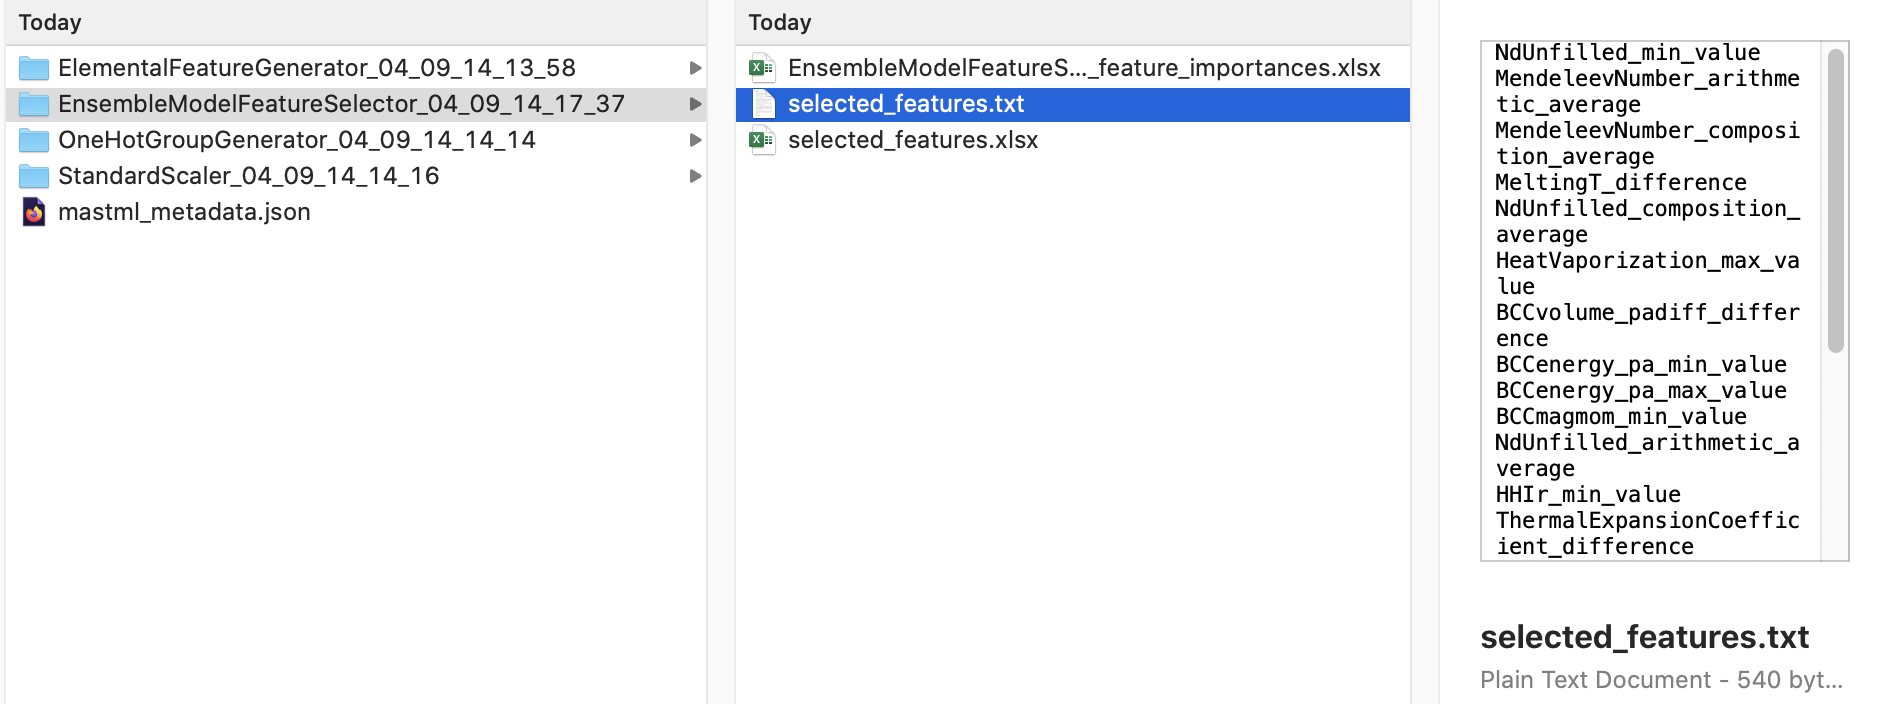

Let's look at our X data once again:

We can see that we now have just 20 columns (features), 
indicating the 20 features that were ranked most highly from
this approach

In [14]:
X

,NdUnfilled_min_value,MendeleevNumber_arithmetic_average,MendeleevNumber_composition_average,MeltingT_difference,BCCenergy_pa_min_value,MeltingT_max_value,HHIr_min_value,HeatVaporization_max_value,BCCenergy_pa_max_value,BCCmagmom_min_value,ElasticModulus_difference,NdUnfilled_composition_average,MendeleevNumber_max_value,NdUnfilled_arithmetic_average,BCCvolume_padiff_difference,HeatFusion_difference,valence_max_value,MiracleRadius_min_value,GSenergy_pa_max_value,IonicRadii_arithmetic_average
0,-0.857637,0.587584,0.587584,-1.276580,0.931053,-1.211603,-0.333888,-1.418039,0.931053,-0.294029,-1.119643,-1.260505,-0.176146,-1.260505,-0.315465,-1.102754,-1.833166,0.859808,0.937419,3.133860
1,0.198447,0.265113,0.265113,-0.564364,0.931053,-0.554667,-0.333888,-0.549465,0.931053,3.811591,-0.067183,-0.495578,-0.176146,-0.495578,-0.315465,-0.709382,-1.194454,-0.730180,0.937419,1.357710
2,0.902504,-0.149493,-0.149493,-0.013905,0.931053,-0.046934,-0.333888,-0.788789,0.931053,-0.294029,0.352156,0.014374,-0.176146,0.014374,-0.315465,-0.324038,0.721682,-0.311762,0.937419,1.251141
3,-0.857637,0.541517,0.541517,-1.112458,0.931053,-1.060219,-0.333888,-1.064931,0.931053,-0.294029,-0.757860,-1.260505,-0.176146,-1.260505,-0.315465,-0.918110,-1.833166,-0.646497,0.937419,1.641894
4,0.550476,0.126911,0.126911,-0.506913,0.931053,-0.501676,-0.333888,-0.717983,0.931053,4.851688,-0.042516,-0.240602,-0.176146,-0.240602,-0.315465,-0.901252,0.721682,-0.730180,0.937419,1.002480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,1.254532,-1.209041,-1.209041,-0.445548,-0.781716,0.655512,0.306424,1.693660,-0.781716,-0.294029,-1.037419,2.309155,-1.993024,2.309155,-0.315465,-0.380234,0.082970,0.776124,-0.787100,0.220974
404,1.606560,-1.162974,-1.162974,0.275928,-0.781716,1.320988,0.306424,2.025739,-0.781716,-0.294029,-0.387855,2.564131,-1.892087,2.564131,-0.315465,0.147206,0.082970,0.943491,-0.787100,0.220974
405,1.958589,-1.393311,-1.393311,-1.026736,-0.781716,-0.111017,-0.227169,0.988435,-0.781716,-0.294029,-0.988085,2.819107,-2.295837,2.819107,-0.315465,-0.552836,-0.555742,0.692440,-0.787100,0.114405
406,1.958589,-1.301176,-1.301176,-0.771548,-0.781716,0.354816,0.306424,1.488111,-0.781716,-0.294029,-0.749637,2.819107,-2.194900,2.819107,-0.315465,-0.605018,-0.555742,2.031377,-0.787100,0.895911


## Task 6: Generate learning curves to assess behavior with data and feature number <a name="task6"></a>

We now have our set of 20 selected features, but we can do another piece of 
analysis to help further our understanding of how we may expect a model
to behave with the feature set we have. We can do this by making two types
of learning curves: the first will use our set of 20 features and assess
how well a model performs as a function of amount of training data. This 
learning curve can help assess whether additional training data may result
in improved model performance. The second will use the full training data 
set and assess how well the model performs as more features are added. 
This second learning curve can help one assess whether more or fewer features 
may be needed to optimize model performance.

In [19]:
LearningCurve().evaluate(model=model,
                        X=X,
                        y=y,
                        savepath=savepath,
                        selector=selector,
                        make_new_dir=True)
Xreduced = copy(X)

Let's check what was output- it can be found in the newly created
"LearningCurve_..." folder. The data_learning_curve.png plot shows the
training and validation mean absolute error (MAE) as a function of number
of training data points. We can see this set may benefit from additional
training data, but the validation score isn't changing too much past
about 250 data points.

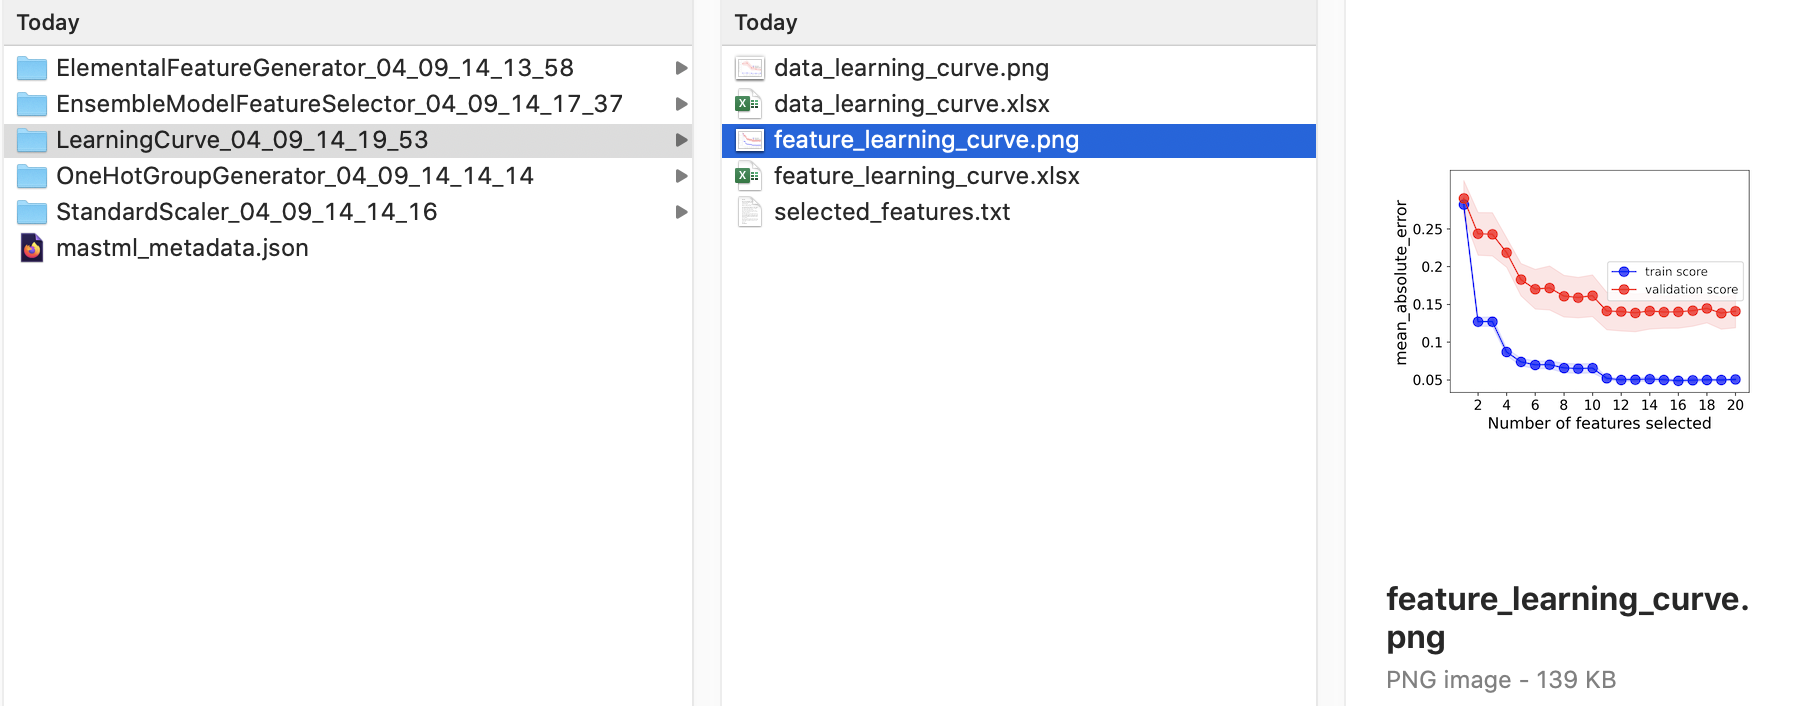


### Data Learning Curve
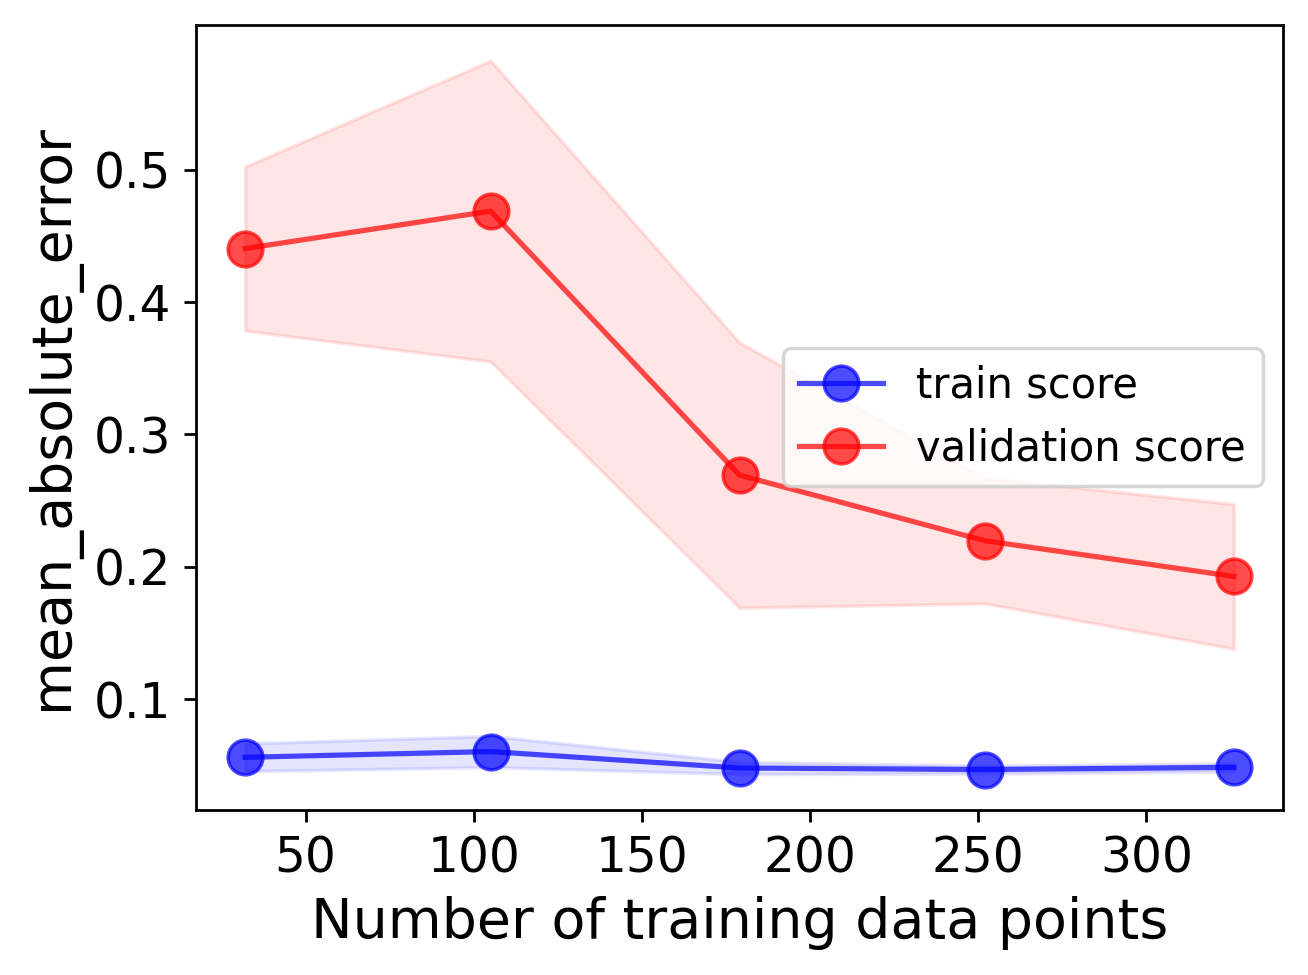

If we look at the feature_learning_curve.png, we see the behavior of the 
model as a function of number of features, from just a single feature
out to the 20 features we selected previously. Here, we can see the
validation score becomes essentially flat after about the 10th feature.
This indicates that we likely only need to use the top 10 features for
our future models.

### Feature Learning Curve
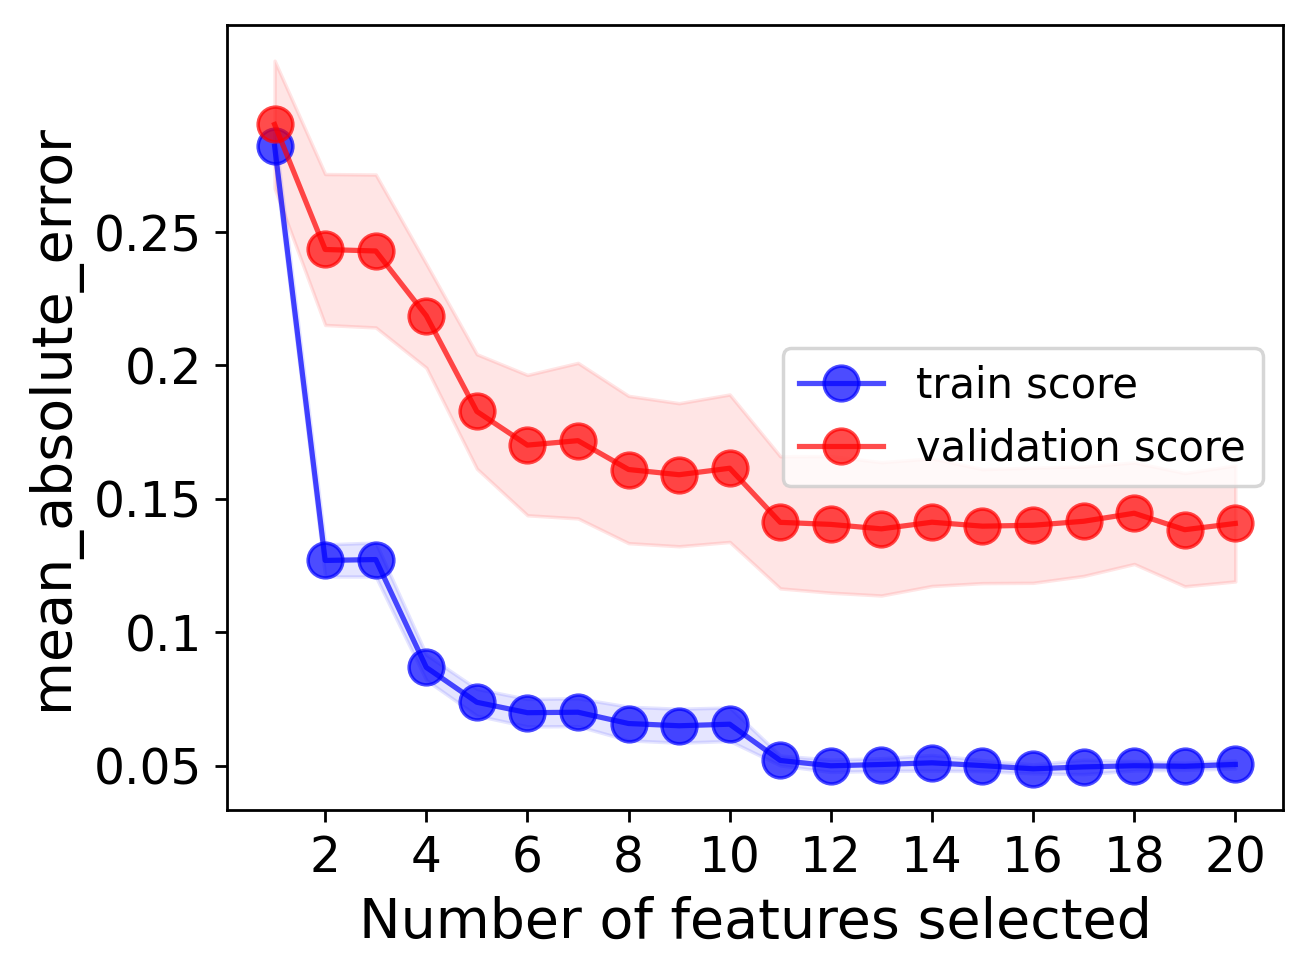

## Task 7: Select features using forward selection <a name="task7"></a>

In the previous two tasks, we performed feature selection using ensemble
models. Now, let's try a slightly more time consuming but often more
accurate method- forward selection. We will start with our X data after
performing the first round of feature selection, and this time re-select
the top 10 features. We will perform the learning curve up to 10 features. 
Which method resulted in the lower validation MAE at 10 features? 
Which features did the superior method find resulting in an improved score?

Be patient- this method will take several minutes to complete!

In [15]:
model = SklearnModel(model='RandomForestRegressor')
selector = SklearnFeatureSelector(selector='SequentialFeatureSelector',
                                  estimator=model.model,
                                  n_features_to_select=10)
X = selector.evaluate(X=X, y=y, savepath=savepath, make_new_dir=True)

LearningCurve().evaluate(model=model,
                        X=Xreduced,
                        y=y,
                        savepath=savepath,
                        selector=selector,
                        make_new_dir=True)

### Feature Learning Curve (forward selection)
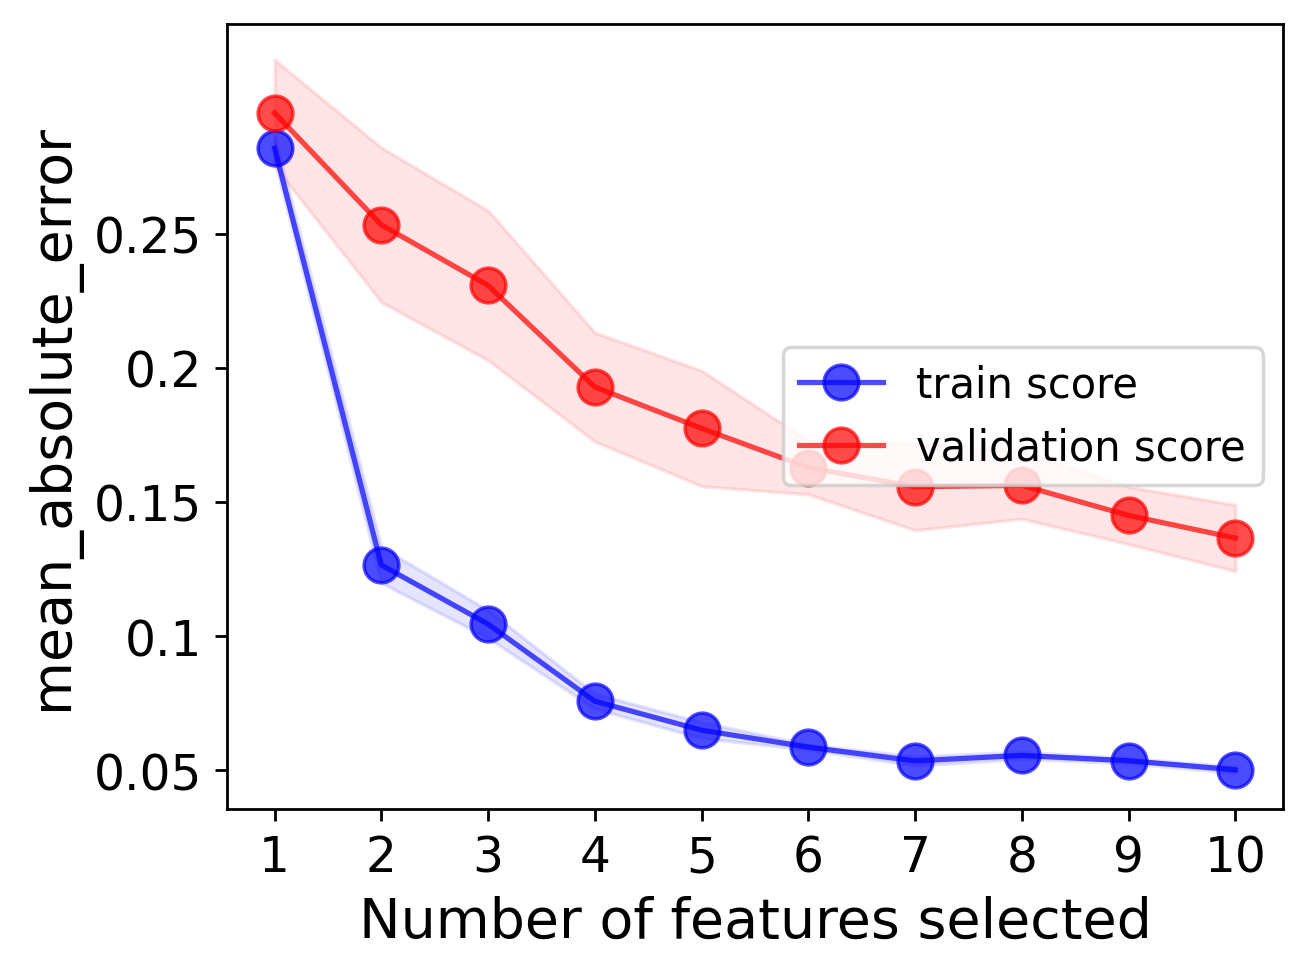

The MAE appears to still be decreasing even at 10 features, while it appeared to start leveling off for the 
previous case of feature selection with an ensemble model. From forward selection, the validation MAE is 0.137 eV, 
while for the ensemble model selection at 10 features the MAE is 0.161 eV. It appears forward selection is doing a better job!

You've now completed your third MAST-ML tutorial notebook! Now that you're more familiar with feature
engineering methods in MAST-ML, the next task is to examine the breadth of models and tests we can perform 
on our data.

The next example in this notebook series is titled MASTML_Tutorial_4_Models_and_Tests.ipynb, and will guide you 
through the process of setting up different types of runs that evaluate a few select model types and perform
different varieties of data split tests.